# Tutorial 1: End-to-end scATAC-seq analysis

Here we will use scATAC-seq dataset `Forebrain' as an example to illustrate how scAGDE performs scATAC-seq analysis in an end-to-end style.

## 1. Read and preprocess data

We first read '.h5ad' data file using [Scanpy](https://github.com/scverse/scanpy) package

In [2]:
import scanpy as sc
adata = sc.read_h5ad("data/Forebrain.h5ad")

We can use Scanpy to further filter data. In our case, we pass this step because the loaded dataset has been preprocessed. Some codes for filtering are copied below for easy reference:

In [3]:
sc.pp.filter_cells(adata, min_genes=100)
min_cells = int(adata.shape[0] * 0.01)
sc.pp.filter_genes(adata, min_cells=min_cells)

In [4]:
adata

AnnData object with n_obs × n_vars = 2088 × 11285
    obs: 'celltype', 'n_genes'
    var: 'n_cells'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## 2. Setup and train scAGDE model

Now we can initialize the trainer with the AnnData object, which will ensure settings for model are in place for training. 

We can specify the `outdir` to the dir path where we want to save the output file (mainly the model weights file).

`n_centroids` represents the cluster number of dataset. If this information is unknown, we can set `n_centroids=None` and in this case, scAGDE will apply the estimation strategy to estimate the optimal cluster number for the initialization of its cluster layer. Here, we set `n_centroids=8`.
 
We can train scAGDE on specified device by setting `gpu`. For example, train scAGDE on CPUs by `gpu=None` and trian it on GPU #0 by `gpu="0"`

<div class='alert alert-block alert-info'>
If you are merely interested in learning cell embeddings without consiering any optimization about cell clustering, you can specify `cluster_opt=False` here. In this case, scAGDE will be run withour any clustering-related module and optimization.
 </div>

In [10]:
import scAGDE
trainer = scAGDE.Trainer(adata,outdir="output",n_centroids=8,gpu="3")

device used: cuda:3



Now we can train scAGDE model in end-to-end style. The whole pipeline behind the function of `fit()` mainly consists of three stages, as below:

1. scAGDE first trained an chromatin accessibility-based autoencoder to measure the importance of the peaks and select the key peaks. The number of selected peaks is set to 10,000 in default, or you can change it by setting `top_n`. In the meanwhile, the initial cell representations for cell graph construction are stored in `adata.obs[embed_init_key]`, which is `"latent_init"` in default.

2. scAGDE then constructed cell graph and trains the GCN-based embedded model to  extract essential structural information from both count and cell graph data.

3. scAGDE finally yiels robust and discriminative cell embeddings which are stored in `adata.obsm[embed_key]`, which is `"latent"` in default. Also, scAGDE enables imputation task if `impute_key` is not None and the imputed data will be stored in `adata.obsm[impute_key]`, which is `"impute"` in default. 

scAGDE performs clustering on final embeddings if `cluster_key` is not None, and the cluster assignments will be in `adata.obs[cluster_key]`, which is `"cluster"` in default. The cluster number is the value of `n_centroids` and if estimation is used, the cluster number is the value of estimated cluster number.

You can also explore each step as you wish by following a step-by-step tutorial in [Tutorial 2: Step-by-Step scATAC-seq analysis](./Tutorial%202:%20Step-by-Step%20scATAC-seq%20analysis.ipynb).

In [6]:
embed_key = "latent"
adata = trainer.fit(topn=10000,embed_key=embed_key)
print(adata)

Cell number: 2088
Peak number: 11285
n_centroids: 8


## Training CountModel ##


CountModel: 100%|██████████| 5000/5000 [00:31<00:00, 158.61it/s, loss=1687.1017]



## Constructing Cell Graph ##
Cell number: 2088
Peak number: 10000
n_centroids: 8


## Training GraphModel ##


GraphModel: 100%|██████████| 4000/4000 [00:51<00:00, 77.59it/s, loss=4249.9907]


AnnData object with n_obs × n_vars = 2088 × 11285
    obs: 'celltype', 'n_genes', 'cluster'
    var: 'n_cells', 'is_selected'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'latent_init', 'impute', 'latent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


## 3. Visualizing and evaluation

We can now use Scanpy to visualize our latent space.

/home/haogaoyang/anaconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/haogaoyang/anaconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


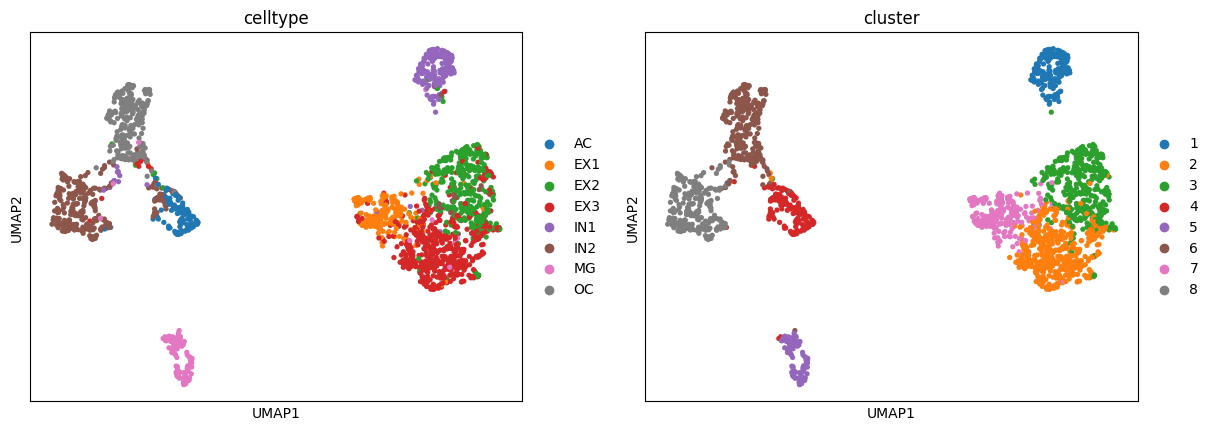

In [7]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata,color=["celltype","cluster"])

We can evaluate the clustering performance with multiple metrics as below:

In [11]:
y = adata.obs["celltype"].astype("category").cat.codes.values
res = scAGDE.utils.cluster_report(y, adata.obs["cluster"].astype(int))


## Clustering Evaluation Report ##
# Confusion matrix: #
[[113   0   0   1   0   3   0   3]
 [  0 175   6   9   0   0   0   0]
 [  1   7 308  42   5   0   0   3]
 [  1  30  64 414   1   2   0   7]
 [  1   3   3   2 171   4   1  10]
 [ 36   0  10   3   3 263   0   5]
 [  2   1   4   3   1   2 108   5]
 [  0   0   0   0   0   1   0 251]]
# Metric values: #
Adjusted Rand Index score: 0.6942
`Normalized Mutual Info score: 0.7389
`f1 score: 0.8635
